# Your Final Project Title

- Member 1: Caren Chua
- Member 2: Abby Salas 
- Member 3: Courtney Collins
- Member 4: Arggin Avanessian

## Introduction

## Research Question

#### "What is the overall distribution of sarcasm in news headlines?",
#### "Are sarcastic headlines more prevalent in certain news categories?",
#### "Do headline length and sentiment have any correlation with sarcasm?"

## Dataset Description

## Preprocessing

In [2]:
!pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.4/770.4 kB 40.7 MB/s eta 0:00:00


In [4]:
!pip install textblob

  Using cached textblob-0.17.1-py2.py3-none-any.whl (636 kB)


In [5]:
# Importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
df = pd.read_csv("Sarcasm_Headlines_Dataset_v2.csv")
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [7]:
df.describe

<bound method NDFrame.describe of        is_sarcastic                                           headline  \
0                 1  thirtysomething scientists unveil doomsday clo...   
1                 0  dem rep. totally nails why congress is falling...   
2                 0  eat your veggies: 9 deliciously different recipes   
3                 1  inclement weather prevents liar from getting t...   
4                 1  mother comes pretty close to using word 'strea...   
...             ...                                                ...   
28614             1       jews to celebrate rosh hashasha or something   
28615             1  internal affairs investigator disappointed con...   
28616             0  the most beautiful acceptance speech this week...   
28617             1  mars probe destroyed by orbiting spielberg-gat...   
28618             1                 dad clarifies this not a food stop   

                                            article_link  
0      https://www

In [10]:
# Research Questions
research_questions = [
    "What is the overall distribution of sarcasm in news headlines?",
    "Are sarcastic headlines more prevalent in certain news categories?",
    "Do headline length and sentiment have any correlation with sarcasm?"
]
print("Research Questions:")
for i, question in enumerate(research_questions):
    print(f"{i+1}. {question}")

Research Questions:
1. What is the overall distribution of sarcasm in news headlines?
2. Are sarcastic headlines more prevalent in certain news categories?
3. Do headline length and sentiment have any correlation with sarcasm?


In [11]:
# Dataset Description
df = pd.read_csv("Sarcasm_Headlines_Dataset_v2.csv")
print(df.describe())

       is_sarcastic
count  28619.000000
mean       0.476397
std        0.499451
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [12]:
# preprocessing
df = df[['headline', 'is_sarcastic']]
df['headline'] = df['headline'].str.lower()
df['headline'] = df['headline'].str.replace('[^\w\s]', '')

/tmp/ipykernel_81/3133958942.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['headline'] = df['headline'].str.replace('[^\w\s]', '')


## Analysis

In [13]:
# Function Definitions
def perform_sentiment_analysis(headlines):
    sentiment_scores = []
    for headline in headlines:
        blob = TextBlob(headline)
        sentiment_scores.append(blob.sentiment.polarity)
    return sentiment_scores

def perform_topic_modeling(headlines):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(headlines)

    lda = LatentDirichletAllocation(n_components=5, random_state=42, learning_method='online', max_iter=10)
    topic_distributions = lda.fit_transform(X)

    return topic_distributions

In [14]:
# Analysis 1: Sentiment Analysis
sentiment_scores = perform_sentiment_analysis(df['headline'])
df['sentiment_score'] = sentiment_scores

In [15]:
# Analysis 2: Topic Modeling
topic_distributions = perform_topic_modeling(df['headline'])
df['topic_distribution'] = topic_distributions.tolist()

## Visualization

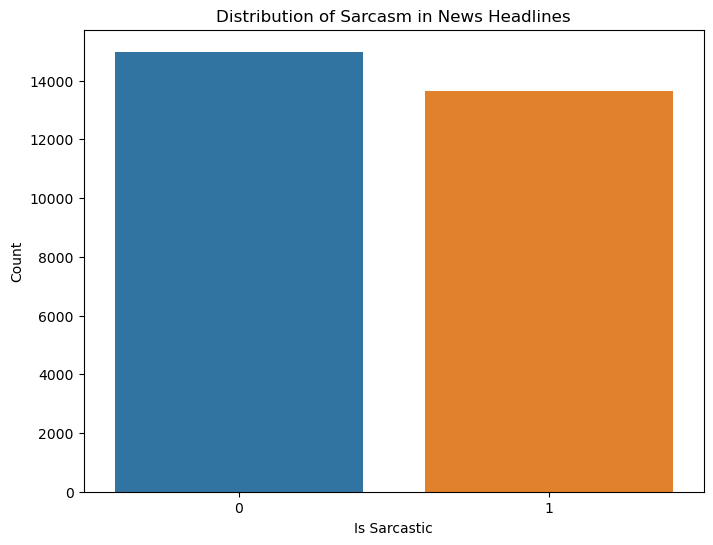

In [16]:
# Visualization 1: Distribution of Sarcasm
plt.figure(figsize=(8, 6))
sns.countplot(x='is_sarcastic', data=df)
plt.xlabel('Is Sarcastic')
plt.ylabel('Count')
plt.title('Distribution of Sarcasm in News Headlines')
plt.show()

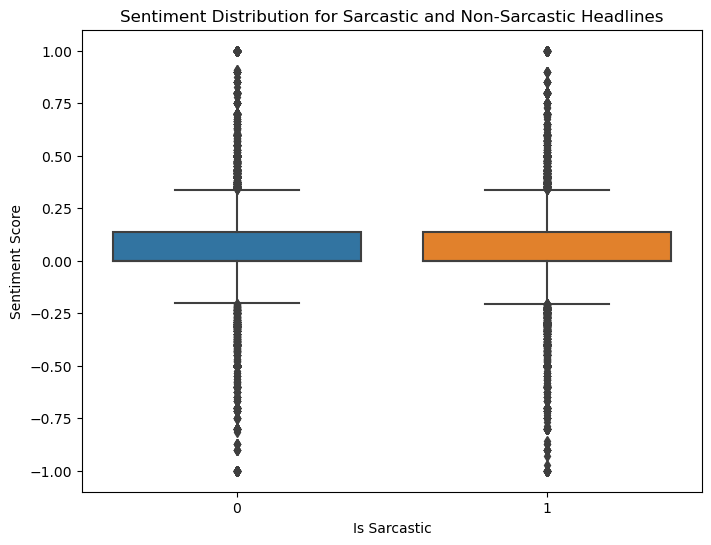

In [17]:
# Visualization 2: Sentiment vs. Sarcasm
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_sarcastic', y='sentiment_score', data=df)
plt.xlabel('Is Sarcastic')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Distribution for Sarcastic and Non-Sarcastic Headlines')
plt.show()

In [19]:
!pip install bokeh

  Using cached bokeh-3.1.1-py3-none-any.whl (8.3 MB)
  Using cached xyzservices-2023.5.0-py3-none-any.whl (56 kB)


In [21]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from sklearn.manifold import TSNE

In [22]:
# Get the topic labels
topics = np.arange(1, topic_distributions.shape[1] + 1)
topic_labels = topics.astype(str)  # Convert to string format

# Get the total weight per topic
topic_weights = topic_distributions.sum(axis=0)

# Set up Bokeh figure and bar plot
output_notebook()
p = figure(x_range=topic_labels, height=400, title='Topic Distribution')
p.vbar(x=topic_labels, top=topic_weights, width=0.9)

# Configure plot settings
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.axis_label = 'Topic'
p.yaxis.axis_label = 'Weight'

# Show the Bokeh plot
show(p)

Loading BokehJS ...

## Results/Findings

## Contribution